# Testing data analysis scripts of a run

In case you only have the h5 files and not the .json

In [2]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time
import sys

In [3]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [121]:
n_shots = 1000
run = '0052_droplets_10um_24mm'
path = '/sf/bernina/data/p17743/res/scan_info/'
# load data                                                                         
file_path = '%srun%s.json'%(path,run)
print('-- Loading data:%s'%file_path)
data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
jf7 = data['JF07T32V01'] # JungFrau data
total_shots = jf7.data.shape[jf7.eventDim]
if (n_shots>total_shots) or (n_shots==0):
    n_shots = total_shots
print('-- JungFrau 16 Mpix detector contains %d shots - analyzing %d shots' % (total_shots, n_shots))

jf_pulse_id = jf7.eventIds[:n_shots] # event ID at 25 Hz
evcodes = data['SAR-CVME-TIFALL5:EvtSet'] # trigger codes in 256 channels at 100 Hz
laser_on = evcodes.data[:,20].compute() # laser trigger at 100 Hz
pulse_id = evcodes.eventIds # event ID at 100 Hz

matched_id = np.isin(pulse_id, jf_pulse_id) # matched IDs at 25 Hz in 100 Hz arrays
assert (np.sum(matched_id) ==  len(jf_pulse_id))
print('-- Asserting that %d matched IDs sum up to %d JF7 event IDs' % (np.sum(matched_id), len(jf_pulse_id)))
laser_on = laser_on[matched_id].astype(np.bool) # laser trigger at 25 Hz

-- Loading data:/sf/bernina/data/p17743/res/scan_info/run0052_droplets_10um_24mm.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension

In [122]:
print('-- Loading corrections')
with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
#with h5py.File('/sf/bernina/data/p17743/res/waterJet_tests/JFpedestal/pedestal_20190125_1507.JF07T32V01.res.h5','r') as f:
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestal/pedestal_20190130_1925.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

-- Loading corrections


In [123]:
t1 = time.time()
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0 #np.nan
avg_img_even = np.zeros_like(icorr_geom)
avg_img_odd = np.zeros_like(icorr_geom)
mask_inv = np.logical_not(mask_geom) #inversed: 0 masked, 1 not masked  
iq_threshold = 5.5
hits_even = 0
hits_odd = 0

# initialise for angular integration                                        
rad_dist = radial_distances(icorr_geom, center=(2117,2222))
ra = RadialAverager(rad_dist, mask_inv)
r  = ra.bin_centers
iq = ra(icorr_geom)
iqs = np.zeros((n_shots, iq.shape[0]))
iqs[0] = iq
print('s.%i, %.1f Hz: %.2f photon/pix' % (1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))

for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7.data[i].compute(),G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    icorr_geom[mask_geom] = 0
    iq = ra(icorr_geom)
    iqs[i] = iq
    if iq[5:80].mean() > iq_threshold:
        if (i % 2) == 0:
            avg_img_even += icorr_geom
            hits_even += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: EVEN HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
        else:
            avg_img_odd += icorr_geom
            hits_odd += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: ODD HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
    else:
        print('s.%i, %.1f Hz: %.2f photon/pix' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
avg_img_even /= hits_even
avg_img_odd /= hits_odd
print('-- DONE! even: %d hits, odd: %d hits, total hitrate: %.1f%%' % (hits_even, hits_odd, 100*(hits_even+hits_odd)/n_shots))

s.1, 0.7 Hz: 0.20 photon/pix
s.2, 2.0 Hz: 0.20 photon/pix
s.3, 2.2 Hz: 0.21 photon/pix
s.4, 2.4 Hz: 0.17 photon/pix
s.5, 2.3 Hz: 0.19 photon/pix
s.6, 2.2 Hz: 0.20 photon/pix
s.7, 2.3 Hz: 0.20 photon/pix
s.8, 2.3 Hz: 0.18 photon/pix
s.9, 2.3 Hz: 0.21 photon/pix
s.10, 2.3 Hz: 0.17 photon/pix
s.11, 2.3 Hz: 0.21 photon/pix
s.12, 2.3 Hz: 0.18 photon/pix
s.13, 2.3 Hz: 0.20 photon/pix
s.14, 2.2 Hz: 0.18 photon/pix
s.15, 2.3 Hz: 0.10 photon/pix
s.16, 2.3 Hz: 0.16 photon/pix
s.17, 2.2 Hz: 0.12 photon/pix
s.18, 2.1 Hz: 0.13 photon/pix
s.19, 2.4 Hz: 0.18 photon/pix
s.20, 2.3 Hz: 0.15 photon/pix
s.21, 2.3 Hz: 0.22 photon/pix
s.22, 2.3 Hz: 0.22 photon/pix
s.23, 2.3 Hz: 0.17 photon/pix
s.24, 2.3 Hz: 0.20 photon/pix
s.25, 2.3 Hz: 0.21 photon/pix
s.26, 2.2 Hz: 0.22 photon/pix
s.27, 2.3 Hz: 0.19 photon/pix
s.28, 2.3 Hz: 0.20 photon/pix
s.29, 2.3 Hz: 0.19 photon/pix
s.30, 2.3 Hz: 0.20 photon/pix
s.31, 2.3 Hz: 0.21 photon/pix
s.32, 2.2 Hz: 0.21 photon/pix
s.33, 2.2 Hz: 0.21 photon/pix
s.34, 2.3 Hz: 0.18 

s.268, 2.3 Hz: 0.19 photon/pix
s.269, 2.4 Hz: 0.20 photon/pix
s.270, 2.4 Hz: 0.20 photon/pix
s.271, 2.4 Hz: 0.22 photon/pix
s.272, 2.3 Hz: 0.20 photon/pix
s.273, 2.3 Hz: 0.22 photon/pix
s.274, 2.4 Hz: 0.22 photon/pix
s.275, 2.3 Hz: 0.23 photon/pix
s.276, 2.4 Hz: 0.19 photon/pix
s.277, 2.4 Hz: 0.20 photon/pix
s.278, 2.4 Hz: 0.22 photon/pix
s.279, 2.3 Hz: 0.17 photon/pix
s.280, 2.3 Hz: 0.20 photon/pix
s.281, 2.2 Hz: 0.23 photon/pix
s.282, 2.3 Hz: 0.18 photon/pix
s.283, 2.3 Hz: 0.19 photon/pix
s.284, 2.3 Hz: 0.21 photon/pix
s.285, 2.3 Hz: 0.23 photon/pix
s.286, 2.3 Hz: 0.18 photon/pix
s.287, 2.3 Hz: 0.21 photon/pix
s.288, 2.3 Hz: 0.20 photon/pix
s.289, 2.3 Hz: 0.21 photon/pix
s.290, 2.3 Hz: 0.14 photon/pix
s.291, 2.3 Hz: 0.14 photon/pix
s.292, 2.2 Hz: 0.15 photon/pix
s.293, 2.3 Hz: 0.18 photon/pix
s.294, 2.3 Hz: 0.19 photon/pix
s.295, 2.3 Hz: 0.21 photon/pix
s.296, 2.2 Hz: 0.22 photon/pix
s.297, 2.3 Hz: 0.19 photon/pix
s.298, 2.3 Hz: 0.19 photon/pix
s.299, 2.3 Hz: 0.21 photon/pix
s.300, 2

s.533, 2.3 Hz: 0.18 photon/pix
s.534, 2.4 Hz: 0.21 photon/pix
s.535, 2.4 Hz: 0.18 photon/pix
s.536, 2.4 Hz: 0.19 photon/pix
s.537, 2.3 Hz: 0.18 photon/pix
s.538, 2.3 Hz: 0.16 photon/pix
s.539, 2.3 Hz: 0.18 photon/pix
s.540, 2.3 Hz: 0.21 photon/pix
s.541, 2.4 Hz: 0.19 photon/pix
s.542, 2.3 Hz: 0.20 photon/pix
s.543, 2.2 Hz: 0.20 photon/pix
s.544, 2.3 Hz: 0.18 photon/pix
s.545, 2.3 Hz: 0.15 photon/pix
s.546, 2.4 Hz: 0.20 photon/pix
s.547, 2.3 Hz: 0.16 photon/pix
s.548, 2.3 Hz: 0.19 photon/pix
s.549, 2.3 Hz: 0.17 photon/pix
s.550, 2.3 Hz: 0.21 photon/pix
s.551, 2.3 Hz: 0.22 photon/pix
s.552, 2.3 Hz: 0.18 photon/pix
s.553, 2.3 Hz: 0.22 photon/pix
s.554, 2.3 Hz: 0.21 photon/pix
s.555, 2.3 Hz: 0.18 photon/pix
s.556, 2.3 Hz: 0.21 photon/pix
s.557, 2.3 Hz: 0.21 photon/pix
s.558, 2.3 Hz: 0.22 photon/pix
s.559, 2.3 Hz: 0.21 photon/pix
s.560, 2.3 Hz: 0.22 photon/pix
s.561, 2.3 Hz: 0.21 photon/pix
s.562, 2.3 Hz: 0.21 photon/pix
s.563, 2.3 Hz: 0.14 photon/pix
s.564, 2.3 Hz: 0.19 photon/pix
s.565, 2

s.797, 2.3 Hz: 0.20 photon/pix
s.798, 2.3 Hz: 0.21 photon/pix
s.799, 2.3 Hz: 0.19 photon/pix
s.800, 2.3 Hz: 0.20 photon/pix
s.801, 2.2 Hz: 0.22 photon/pix
s.802, 2.3 Hz: 0.20 photon/pix
s.803, 2.3 Hz: 0.21 photon/pix
s.804, 2.3 Hz: 0.21 photon/pix
s.805, 2.3 Hz: 0.20 photon/pix
s.806, 2.3 Hz: 0.19 photon/pix
s.807, 2.3 Hz: 0.22 photon/pix
s.808, 2.3 Hz: 0.17 photon/pix
s.809, 2.3 Hz: 0.20 photon/pix
s.810, 2.3 Hz: 0.16 photon/pix
s.811, 2.4 Hz: 0.20 photon/pix
s.812, 2.3 Hz: 0.18 photon/pix
s.813, 2.3 Hz: 0.15 photon/pix
s.814, 2.4 Hz: 0.16 photon/pix
s.815, 2.3 Hz: 0.17 photon/pix
s.816, 2.2 Hz: 0.43 photon/pix: ODD HIT
s.817, 2.3 Hz: 0.20 photon/pix
s.818, 2.3 Hz: 0.19 photon/pix
s.819, 2.3 Hz: 0.16 photon/pix
s.820, 2.3 Hz: 0.15 photon/pix
s.821, 2.3 Hz: 0.13 photon/pix
s.822, 2.3 Hz: 0.16 photon/pix
s.823, 2.3 Hz: 0.19 photon/pix
s.824, 2.3 Hz: 0.18 photon/pix
s.825, 2.3 Hz: 0.19 photon/pix
s.826, 2.3 Hz: 0.19 photon/pix
s.827, 2.3 Hz: 0.18 photon/pix
s.828, 2.3 Hz: 0.13 photon/pix

<IPython.core.display.Javascript object>


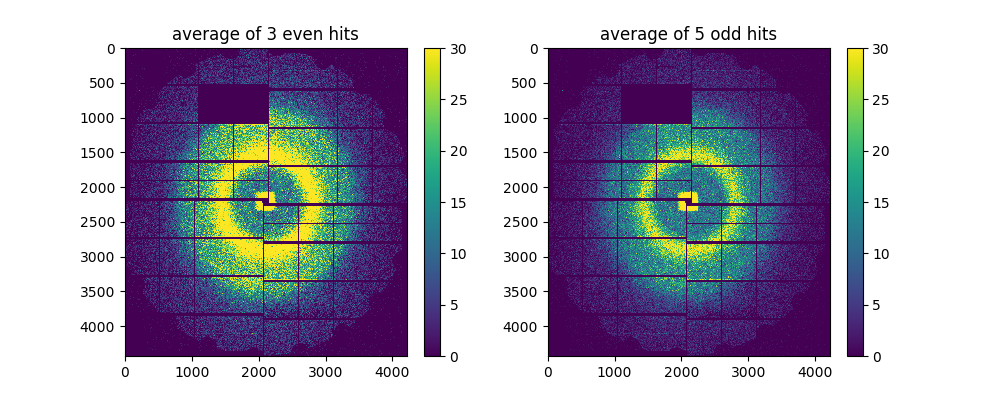

In [124]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d even hits' % hits_even)
plt.imshow(avg_img_even,aspect='auto',clim=[0,30])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('average of %d odd hits' % hits_odd)
plt.imshow(avg_img_odd,aspect='auto',clim=[0,30])
plt.colorbar()

plt.savefig('run%s_2d_hits_even_vs_odd.png' % run)
plt.show()

In [125]:
iq_metric = iqs[:,5:80].mean(axis=1)
bi,bf,db = iq_metric.min(),iq_metric.max(),.5
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

<IPython.core.display.Javascript object>


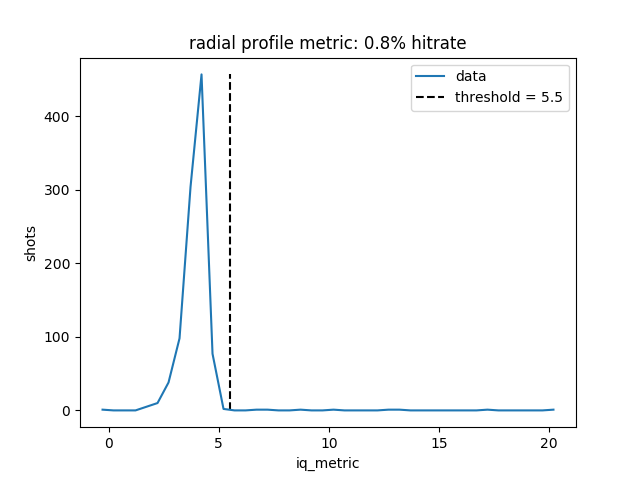

In [126]:
iq_threshold = 5.5
hits = iq_metric > iq_threshold
plt.figure()
plt.title('radial profile metric: %.1f%% hitrate' % (100*hits.sum()/n_shots))
plt.plot(bin_centers, hy, label='data')
plt.ylabel('shots')
plt.xlabel('iq_metric')
plt.vlines(iq_threshold,0,hy.max(),color='k',linestyles='dashed',label='threshold = %.1f' % iq_threshold)
plt.legend()
plt.savefig('run%s_radial_profile_hist.png' % run)
plt.show()

In [127]:
q = q_scale(r, detector_distance=0.12) # detector_distance=0.127 m according to Alex measurement
iqs_even = iqs[::2]
iqs_odd = iqs[1::2]
iq_avg_even = iqs_even[iq_metric[::2] > iq_threshold].mean(axis=0)
iq_avg_odd = iqs_odd[iq_metric[1::2] > iq_threshold].mean(axis=0)

<IPython.core.display.Javascript object>


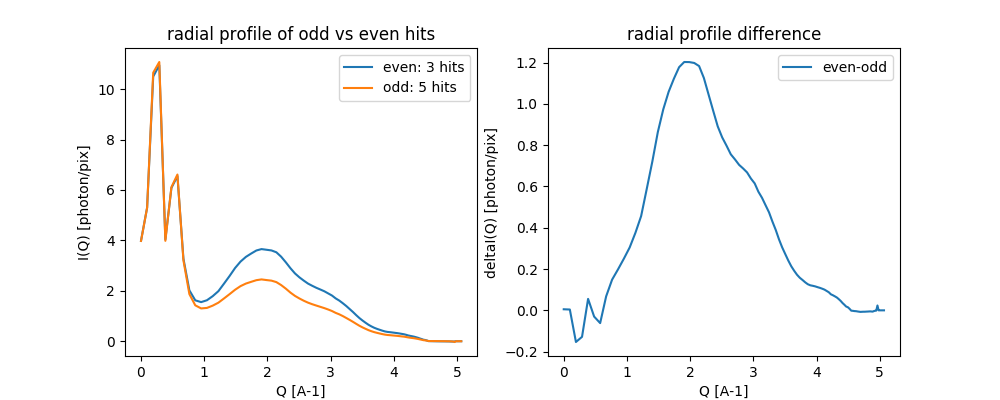

In [128]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/9.5, label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/9.5, label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
plt.plot(q, (iq_avg_even-iq_avg_odd)/9.5, label='even-odd')
plt.ylabel('deltaI(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.savefig('run%s_radial_profile_even_vs_odd.png' % run)
plt.show()

<IPython.core.display.Javascript object>


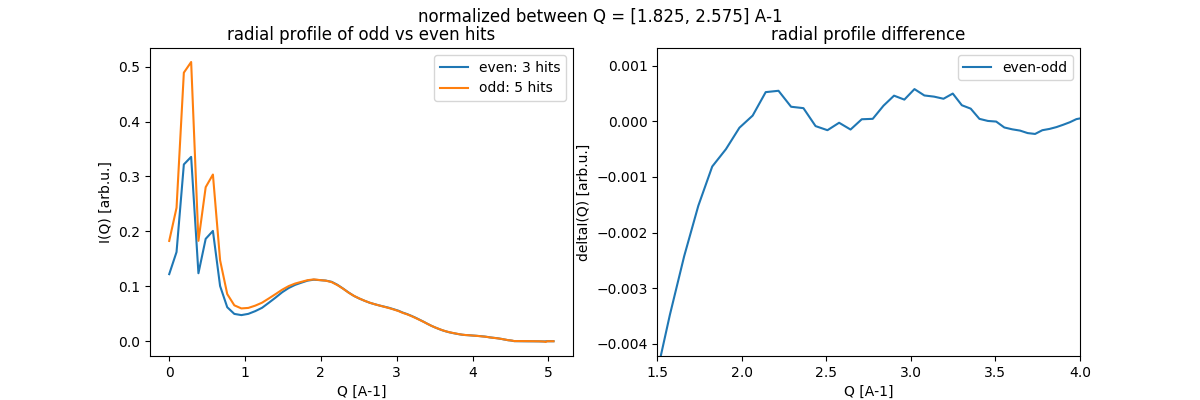

In [129]:
plt.figure(figsize=[12,4])
plt.suptitle('normalized between Q = [%.03f, %.03f] A-1' % (q[20], q[30]))
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/iq_avg_even[20:30].sum(), label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/iq_avg_odd[20:30].sum(), label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
iq_diff_norm = (iq_avg_even/iq_avg_even[20:30].sum()-iq_avg_odd/iq_avg_odd[20:30].sum())
plt.plot(q, iq_diff_norm, label='even-odd')
plt.ylabel('deltaI(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.xlim([1.5,4.0])
plt.ylim([iq_diff_norm[17:60].min() - iq_diff_norm[17:60].std(), iq_diff_norm[17:60].max() + iq_diff_norm[17:60].std()])
plt.legend()
#plt.tight_layout()

plt.savefig('run%s_radial_profile_even_vs_odd_normalized+zoom.png' % run)
plt.show()

In [130]:
def normalize(array, lower_index, upper_index):
    n = np.sum(array[lower_index:upper_index])
    norm_array = array / n
    return norm_array

l = 20
h = 30

hit_avg  = np.average(iqs[hits,:], axis=0)/9.5 # to convert to photon/pix
miss_avg = np.average(iqs[np.logical_not(hits),:], axis=0)/9.5 # to convert to photon/pix

off_miss = np.average(iqs[np.logical_not(hits) * np.logical_not(laser_on),:], axis=0)
on_miss  = np.average(iqs[np.logical_not(hits) * laser_on,:], axis=0)
off_hit  = np.average(iqs[hits * np.logical_not(laser_on),:], axis=0)
on_hit   = np.average(iqs[hits * laser_on,:], axis=0)

signal = (normalize(on_hit, l, h) - normalize(off_hit, l, h)) # / normalize(off_hit, l, h)

# get a number of off hits equal to the number of on hits for SNR estimation
off_hits = iqs[hits * np.logical_not(laser_on),:]
off_hits_1 = np.average(off_hits[:-1:2], axis=0)
off_hits_2 = np.average(off_hits[1::2], axis=0)
off_diff = normalize(off_hits_1, l, h) - normalize(off_hits_2, l, h)

<IPython.core.display.Javascript object>


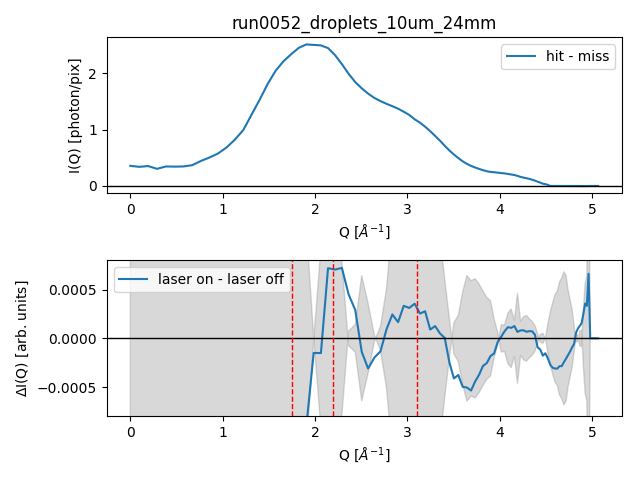

In [133]:
plt.figure()

plt.subplot(2,1,1)
plt.title('run%s'%run)
plt.plot(q, hit_avg - miss_avg)
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(['hit - miss'])
plt.axhline(0,c='black',lw=1)

ax = plt.subplot(2,1,2)
ax.plot(q, signal)
ax.fill_between(q, -off_diff, off_diff, color='grey', alpha=0.3)
plt.xlabel('q')
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-8e-4,8e-4])
plt.xlabel('Q [$\AA^{-1}$]')
plt.axhline(0,c='black',lw=1)
plt.axvline(1.75,c='red',lw=1,ls='--')
plt.axvline(2.2,c='red',lw=1,ls='--')
plt.axvline(3.1,c='red',lw=1,ls='--')
plt.legend(['laser on - laser off'])
plt.tight_layout()


plt.savefig('run%s_radial_profile_on_vs_off_normalized.png' % run)
plt.show()